In [29]:
import numpy as np
import pandas as pd
from pathlib import Path
from colors import strip_color
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import array
import math
from scipy.stats import norm
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator


%matplotlib inline 

sns.set_style("whitegrid")
sns.set_palette("Blues")

In [2]:
LOG_PATH = Path('./log/')
DATA_PATH = Path('./data/')
PAPER_FIG_PATH = Path('../../orazor-paper/images/')

## LoCs

In [3]:
loc_df = pd.read_csv('./data/diff.csv')
loc_df

def total_locs(df):
    locs = 0
    for _, row in df.iterrows():
        if row['name'].endswith('.go') and row['name'].find('address_list') == -1 and row['name'].find('cpuminer') == -1 and row['name'].find('vrf') == -1:
            print('%s: %d, %d' % (row['name'], int(row['delete']), int(row['add'])))
            locs -= int(row['delete'])
            locs += int(row['add'])
            
    return locs

total_locs(loc_df)

blockchain/accept.go: 5, 5
blockchain/blockindex.go: 10, 39
blockchain/chain.go: 2, 32
blockchain/chainio.go: 0, 21
blockchain/committee.go: 0, 82
blockchain/orazor.go: 0, 231
blockchain/process.go: 1, 50
blockchain/weight.go: 2, 2
chaincfg/extension.go: 0, 102
chaincfg/params.go: 0, 5
config.go: 2, 66
limits_plan9.go: 10, 0
limits_unix.go: 52, 0
limits_windows.go: 10, 0
netsync/interface.go: 0, 5
netsync/manager.go: 14, 164
peer/log.go: 0, 3
peer/peer.go: 1, 9
rpcserver.go: 0, 66
server.go: 1176, 54
serverpeer.go: 0, 1164
wire/common.go: 0, 31
wire/message.go: 0, 4
wire/msgblock.go: 1, 2
wire/msgvote.go: 0, 69


920

## Log processing

In [4]:
def get_files(extension, committee_size, latency, minerblocksize, block_interval=4, epoch_size=1):
    log_folder = '%s_%d_%d_%d_%d_%d' % (extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    data_path = LOG_PATH / log_folder
    log_files = [x for x in data_path.iterdir() if x.name.endswith('.log')]
    dstat_files = [x for x in data_path.iterdir() if x.name.endswith('.csv')]
    return log_files, dstat_files

In [5]:
def _sanitize(s):
    s = strip_color(s)
    s = s.strip('[1;38;5;8m')
    s = s.strip('\n')
    return s

def _get_time(s):
    dt_str = s[0:23]
    return datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')

def get_blocks(log_file):
    blocks = dict()
    for line in open(log_file.absolute()):
        block = dict()
        line = _sanitize(line)
        if line.find('Block submitted via CPU miner accepted') != -1: # mined a block
            blockhash = line.split(' ')[-4].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'mined_time' not in blocks[blockhash]:
                blocks[blockhash]['mined_time'] = _get_time(line)
#         if line.find('PEER: Received block (hash') != -1: # received a block
#             blockhash = line.split(' ')[7].strip(',')
        if line.find('SYNC: received block') != -1: # received a block
            blockhash = line.split(' ')[6].strip(',')
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'received_time' not in blocks[blockhash]:
                blocks[blockhash]['received_time'] = _get_time(line)
        if line.find('has been finalised') != -1: # finalised
            blockhash = line.split(' ')[-4]
            if blockhash not in blocks.keys():
                blocks[blockhash] = dict()
            if 'finalised_time' not in blocks[blockhash]:
                blocks[blockhash]['finalised_time'] = _get_time(line)
    
    non_finalised_blocks = dict()
    for blockhash in blocks.keys():
        if 'finalised_time' not in blocks[blockhash]:
            non_finalised_blocks[blockhash] = blocks[blockhash]
            continue
        
    for blockhash in non_finalised_blocks:
        del blocks[blockhash]
    
    return blocks, non_finalised_blocks

# TODO (RH) rerun psyncorazor_64_5_{20,40}
# lfiles, dfiles = get_files('syncorazor', 64, 5, 10)
# blocks, _ = get_blocks(lfiles[3])
# for blockhash in blocks.keys():
#     print(blocks[blockhash])

## Block propagation delay

In [6]:
def get_bpds(extension, committee_size, latency, minerblocksize, block_interval=4, epoch_size=1):
    # dict{block: [gap1, gap2, ...]}
    bpd_dict = dict()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    for lf in lfiles:
        blocks, _ = get_blocks(lf)
        for blockhash, block in blocks.items():
            if blockhash not in bpd_dict.keys():
                bpd_dict[blockhash] = dict()
                bpd_dict[blockhash]['received_times'] = list()
            if 'mined_time' in block.keys():
                bpd_dict[blockhash]['mined_time'] = block['mined_time']
            elif 'received_time' in block.keys():
                bpd_dict[blockhash]['received_times'].append(block['received_time'])
    
    bpds = list()
    for blockhash, block in bpd_dict.items():
        if 'mined_time' not in block.keys():
            continue
        for received_time in block['received_times']:
            bpd = received_time - block['mined_time']
            bpds.append(bpd.seconds*1000 + bpd.microseconds/1000)
    
    return bpds

def save_bpds_stats(extension, committee_sizes, latency, minerblocksizes):
    df = pd.DataFrame()
    for committee_size in committee_sizes:
        for minerblocksize in minerblocksizes:
            bpds = get_bpds(extension, committee_size, latency, minerblocksize)
            for bpd in bpds:
                line = {
                    'extension': extension, 
                    'committee_size': committee_size, 
                    'latency': latency, 
                    'minerblocksize': minerblocksize, 
                    'bpd': bpd
                }
                df = df.append(line, ignore_index=True)
                
    df.to_csv(DATA_PATH / 'bpd.csv')
    return df

# bpds_df = save_bpds_stats('syncorazor', [4,8,16,32,64,128], 5, [10,20,40,60])
# bpds_df

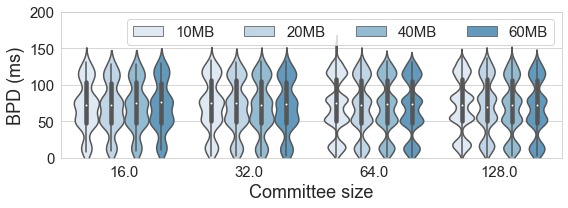

In [7]:
bpds_df = pd.read_csv(DATA_PATH / 'bpd.csv')

def plot_bpd(df, committee_sizes, minerblocksizes):
    filtered_df = df[(df['bpd'] < 200) & (df['committee_size'].isin(committee_sizes)) & (df['minerblocksize'].isin(minerblocksizes))]
    plt.figure(figsize=(8,3))
    ax = sns.violinplot(x='committee_size', y='bpd', hue='minerblocksize', data=filtered_df)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Committee size', fontsize=18)
    plt.ylabel('BPD (ms)', fontsize=18)
    plt.ylim([0, 200])
    plt.legend(fontsize=18)
    ax.legend(handles=ax.legend_.legendHandles, labels=['10MB', '20MB', '40MB', '60MB'], fontsize=15, ncol=4)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'bpd.pdf')
    plt.show()

plot_bpd(bpds_df, [16,32,64,128], [10,20,40,60])

## Block finalisation latency

In [8]:
def get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize, block_interval=4, epoch_size=1):
    # dict{block: [gap1, gap2, ...]}
    delay_dict = dict()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    for lf in lfiles:
        blocks, _ = get_blocks(lf)
        for blockhash, block in blocks.items():
            if blockhash not in delay_dict.keys():
                delay_dict[blockhash] = dict()
                delay_dict[blockhash]['finalised_times'] = list()
            if 'mined_time' in block:
                delay_dict[blockhash]['mined_time'] = block['mined_time']
            if 'finalised_time' in block:
                 delay_dict[blockhash]['finalised_times'].append(block['finalised_time'])
    
    latencies = []
    for block, block_delay in delay_dict.items():
        if 'mined_time' not in block_delay:
            continue
        for finalised_time in block_delay['finalised_times']:
            latency = finalised_time - block_delay['mined_time']
            latencies.append(latency.seconds*1000 + latency.microseconds/1000)
    
    latencies_array = np.array(latencies)
    return latencies_array.mean(), latencies_array.std()

def save_latency_stats(extensions, committee_sizes, latencies, minerblocksizes):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    mean, std = get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize)
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'mean': mean, 
                        'std': std
                    }
                    df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'latency.csv')
    return df

# latency_df = save_latency_stats(['syncorazor', 'psyncorazor'], [4,8,16,32,64,128], [5], [10,20,40,60])
# latency_df

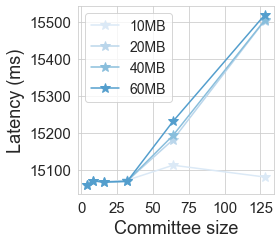

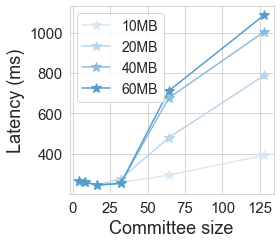

In [10]:
latency_df = pd.read_csv(DATA_PATH / 'latency.csv')

extensions = ['syncorazor', 'psyncorazor']
committee_sizes = [4,8,16,32,64,128]
latency = 5
minerblocksizes = [10, 20, 40, 60]

def plot_latency(df, extension, committee_sizes, minerblocksizes):
    plt.figure(figsize=(4, 3.5))

    for minerblocksize in minerblocksizes:
        lines = df[(df['extension']==extension) & (df['committee_size'].isin(committee_sizes)) & (df['latency']==latency) & (df['minerblocksize']==minerblocksize)]
        delay_means = lines['mean']
        delay_stds = lines['std']
#         plt.errorbar(committee_sizes, delay_means, yerr=delay_stds, label="%dMB" % minerblocksize)
        plt.plot(committee_sizes, delay_means, '-*', label="%dMB" % minerblocksize, markersize=10)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Committee size', fontsize=18)
    plt.ylabel('Latency (ms)', fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / ('latency-%s.pdf' % extension))
    plt.show()

plot_latency(latency_df, 'syncorazor', [4,8,16,32,64,128], [10,20,40,60])
plot_latency(latency_df, 'psyncorazor', [4,8,16,32,64,128], [10,20,40,60])

## Network bandwidth utilisation

In [27]:
def get_bw_util(extension, committee_size, latency, minerblocksize, block_interval=1, epoch_size=1):
    _, dfiles = get_files(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    recvs, sends = [], []
    for dfile in dfiles:
        df = pd.read_csv(dfile.absolute(), skiprows=6)
        recvs.append(df['recv'].mean())
        sends.append(df['send'].mean())
    return np.array(recvs).mean(), np.array(sends).mean() # all in Bytes

def save_bw_util(extensions, committee_sizes, latencies, minerblocksizes):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    recv, send = get_bw_util(extension, committee_size, latency, minerblocksize)
                    line = {
                        'extension': extension, 
                        'committee_size': committee_size, 
                        'latency': latency, 
                        'minerblocksize': minerblocksize, 
                        'recv': recv, 
                        'send': send
                    }
                    df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'bw_util.csv')
    return df

# bw_df = save_bw_util(['syncorazor', 'psyncorazor'], [4,8,16,32,64,128], [5], [10,20,40,60])
# bw_df

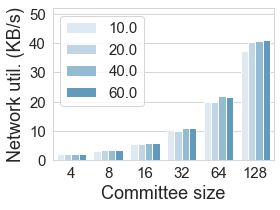

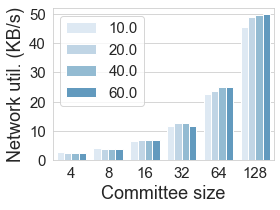

In [33]:
bw_df = pd.read_csv(DATA_PATH / 'bw_util.csv')

def plot_bw_util(df, extension, committee_sizes, minerblocksizes):
    plt.figure(figsize=(4, 3))
    filtered_df = df[df['extension'] == extension]
    filtered_df = filtered_df.astype({"committee_size": int})

    total_utils = list()
    for index, row in filtered_df.iterrows():
        total_utils.append((row['recv'] + row['send'])/1000)
    filtered_df.insert(loc=1, column="total", value=total_utils)
    ax = sns.barplot(x='committee_size', y='total', hue='minerblocksize', data=filtered_df)
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Committee size', fontsize=18)
    plt.ylabel('Network util. (KB/s)', fontsize=18)
    plt.ylim([0, 52])
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / ('bw-util-%s.pdf' % extension))
    plt.show()

plot_bw_util(bw_df, 'syncorazor', [4,8,16,32,64,128], [10,20,40,60])
plot_bw_util(bw_df, 'psyncorazor', [4,8,16,32,64,128], [10,20,40,60])

## Fork rate

- extension: psync
- committee size: 128
- block size: 10, 20, 40, 60
- interval: 1, 2, 3, 4

In [95]:
def get_fork_rates(extension, committee_size, latency, minerblocksize, block_interval=4):
    fork_rates = list()
    lfiles, _ = get_files(extension, committee_size, latency, minerblocksize, block_interval=block_interval)
    for lf in lfiles:
        blocks, non_finalised_blocks = get_blocks(lf)
        if len(blocks)+len(non_finalised_blocks) == 0:
            continue
        fork_rate = len(non_finalised_blocks) / (len(blocks)+len(non_finalised_blocks))
        fork_rates.append(fork_rate)
    
    return np.array(fork_rates)

def save_fork_rates(extensions, committee_sizes, latencies, minerblocksizes, block_intervals):
    df = pd.DataFrame()
    for extension in extensions:
        for committee_size in committee_sizes:
            for latency in latencies:
                for minerblocksize in minerblocksizes:
                    for block_interval in block_intervals:
                        frs = get_fork_rates(extension, committee_size, latency, minerblocksize, block_interval)
                        line = {
                            'extension': extension, 
                            'committee_size': committee_size, 
                            'latency': latency, 
                            'minerblocksize': minerblocksize, 
                            'block_interval': block_interval,
                            'mean': frs.mean(), 
                            'std': frs.std()
                        }
                        df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'fork_rates.csv')
    return df

# fork_rates_df = save_fork_rates(['psyncorazor'], [128], [5], [10,20,40,60], [1,2,3,4])
# fork_rates_df

,block_interval,committee_size,extension,latency,mean,minerblocksize,std
0,1.0,128.0,psyncorazor,5.0,0.005147,10.0,0.005005
1,2.0,128.0,psyncorazor,5.0,0.005697,10.0,0.006355
2,3.0,128.0,psyncorazor,5.0,0.000091,10.0,0.001024
3,4.0,128.0,psyncorazor,5.0,0.000000,10.0,0.000000
4,1.0,128.0,psyncorazor,5.0,0.007195,20.0,0.005563
5,2.0,128.0,psyncorazor,5.0,0.012762,20.0,0.019038
6,3.0,128.0,psyncorazor,5.0,0.009579,20.0,0.010421
7,4.0,128.0,psyncorazor,5.0,0.003571,20.0,0.007167
8,1.0,128.0,psyncorazor,5.0,0.012695,40.0,0.010816
9,2.0,128.0,psyncorazor,5.0,0.013622,40.0,0.010647


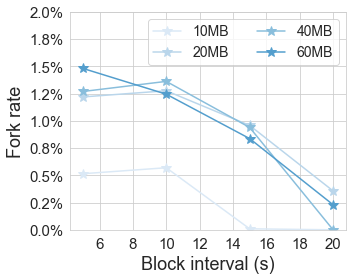

In [35]:
fork_rates_df = pd.read_csv(DATA_PATH / 'fork_rates.csv')

def plot_fork_rates(df, minerblocksizes, block_intervals):
    plt.figure(figsize=(5, 4))
    for minerblocksize in minerblocksizes:
        xs = df[df['minerblocksize']==minerblocksize]['block_interval'] * 5
        means = df[df['minerblocksize']==minerblocksize]['mean']
        stds = df[df['minerblocksize']==minerblocksize]['std']
        plt.plot(xs, means, '-*', label="%dMB" % minerblocksize, markersize=10)
#         plt.errorbar(xs, means, yerr=stds, label="%dMB" % minerblocksize)

    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=1))
    plt.xlabel('Block interval (s)', fontsize=18)
    plt.ylabel('Fork rate', fontsize=18)
    plt.ylim([0, 0.02])
    plt.legend(fontsize=14, ncol=2)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'fork-rate.pdf')
    plt.show()

plot_fork_rates(fork_rates_df, [10,20,40,60], [1,2,3,4])

## Razor throughput vs latency

- committee size: 256
- block interval: 2s
- block size: {10, 50, 100, 150, 200}
- epoch size: {1, 5, 10}

In [43]:
tx_size = 512

def get_tps_latency(extension, committee_size, latency, minerblocksize, block_interval=4, epoch_size=1):
    tps = minerblocksize*1024*1024/tx_size/(block_interval*latency)
    mean_latency, _ = get_finalisation_latency_stats(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
    return tps, mean_latency

def save_tps_latency_stats(tuples): # [(minerblocksize, epoch_size)...]
    extension = 'psyncorazor'
    committee_size = 256
    latency = 2
    block_interval = 1
    df = pd.DataFrame()
    for t in tuples:
        minerblocksize = t[0]
        epoch_size = t[1]
        tps, mean_latency = get_tps_latency(extension, committee_size, latency, minerblocksize, block_interval, epoch_size)
        line = {
            'extension': extension, 
            'committee_size': committee_size, 
            'latency': latency, 
            'minerblocksize': minerblocksize, 
            'epoch_size': epoch_size,
            'tps': tps, 
            'mean_latency': mean_latency
        }
        df = df.append(line, ignore_index=True)
    df.to_csv(DATA_PATH / 'tps_latency.csv')
    return df

tps_latency_df = save_tps_latency_stats(
    [
        [10, 5],
        [100, 5],
        [200, 5],
        [300, 5],
        [10, 10],
        [100, 10]
    ]
)
tps_latency_df

,committee_size,epoch_size,extension,latency,mean_latency,minerblocksize,tps
0,256.0,5.0,psyncorazor,2.0,5220.406402,10.0,10240.0
1,256.0,5.0,psyncorazor,2.0,5605.481652,100.0,102400.0
2,256.0,5.0,psyncorazor,2.0,5971.715311,200.0,204800.0
3,256.0,5.0,psyncorazor,2.0,6232.753015,300.0,307200.0
4,256.0,10.0,psyncorazor,2.0,10501.266991,10.0,10240.0
5,256.0,10.0,psyncorazor,2.0,11392.914790,100.0,102400.0


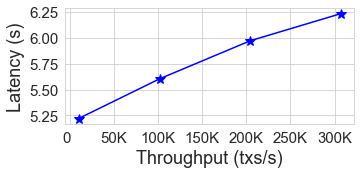

In [107]:
def format_func(value, tick_number=None):
    num_thousands = 0 if abs(value) < 1000 else int(np.floor(np.log10(abs(value))/3))
    value = round(value / 1000**num_thousands, 2)
    return f'{value:g}'+' KMGTPEZY'[num_thousands]

def plot_tps_latency(df, epoch_sizes):
    plt.figure(figsize=(5, 2.5))
    
    for epoch_size in epoch_sizes:
        filtered_df = df[df['epoch_size'] == epoch_size]
        plt.plot(filtered_df['tps'], filtered_df['mean_latency']/1000, '-*', markersize=10, color='blue')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(format_func))
    plt.xlabel('Throughput (txs/s)', fontsize=18)
    plt.ylabel('Latency (s)', fontsize=18)
#     plt.legend(fontsize=15, ncol=2)
    plt.tight_layout()
    plt.savefig(PAPER_FIG_PATH / 'tps-latency.pdf')
    plt.show()

plot_tps_latency(tps_latency_df, [5])